## Classifying Palmer Penguins

#### Importing packages and reading in our data 

In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
from mlxtend.plotting import plot_decision_regions
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import random

train_url = "https://raw.githubusercontent.com/middlebury-csci-0451/CSCI-0451/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)
train = train.loc[train["Sex"].isin(['MALE', 'FEMALE'])]

test_url = "https://raw.githubusercontent.com/middlebury-csci-0451/CSCI-0451/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)

#### Data Acknowledgment 
Data used in this blog post were collected and made available by Dr. Kristen Gorman and the Palmer Station, Antarctica LTER, a member of the Long Term Ecological Research Network. The subjects of the data are these guys:  
![Cute Fellas](penguins.jpg)  
The Adelie Penguin,   
![Adelie](adelie.jpg)  
The Chinstrap Penguin,   
![Chinstrap](chistrap.jpg)  
and The Gentoo Penguin  
![Gentoo](gentoo.jpg)

#### Building the Model
The aim of this post was to identify a subset of the available features that could be used to train a classification model. To accomplish this task, we must first prepare the data accordingly, which we do using the following function prepare_data. This function drops identifying information from the study which will not be useful in predictive modeling, as well as separating the target vector from the rest of the dataset.

In [43]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(train)
X_test, y_test = prepare_data(test)

With our data appropriately cleaned and partitioned, we can now begin to formulate a model. The model of choice here is a random forest, which is an ensemble method made up of multiple decision trees. These individual trees are created from random independent samples or subsets of data, whose decisions are averaged in making predictions. To effectively choose features that accurately predict penguin species, we can build multiple models using different, independent combinations of columns. We can evaluate each of these models and score them to quantify their performance and choose the combination which obtains the highest score. The following block of code selects a unique subset of columns, both qualitative and quantitative, trains a model using the partitioned training dataset, and tests its accuracy on the testing dataset.

In [44]:
from itertools import combinations
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score

all_qual_cols = ["Island", "Sex", "Clutch Completion"]
all_quant_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)']

for qual in all_qual_cols: 
  qual_cols = [col for col in X_train.columns if qual in col ]
  for pair in combinations(all_quant_cols, 2):
    cols = list(pair) + qual_cols
    print("Columns: " + str(cols))
    rfc = RandomForestClassifier()
    X_train_curr = X_train[cols]
    rfc.fit(X_train_curr, y_train)
    preds = rfc.predict(X_test[cols])
    print("Model Score: " + str(accuracy_score(y_test, preds)))
    
    

Columns: ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen']
Model Score: 0.9852941176470589
Columns: ['Culmen Length (mm)', 'Flipper Length (mm)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen']
Model Score: 0.9852941176470589
Columns: ['Culmen Depth (mm)', 'Flipper Length (mm)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen']
Model Score: 0.8529411764705882
Columns: ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Sex_FEMALE', 'Sex_MALE']
Model Score: 0.9852941176470589
Columns: ['Culmen Length (mm)', 'Flipper Length (mm)', 'Sex_FEMALE', 'Sex_MALE']
Model Score: 1.0
Columns: ['Culmen Depth (mm)', 'Flipper Length (mm)', 'Sex_FEMALE', 'Sex_MALE']
Model Score: 0.8088235294117647
Columns: ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Clutch Completion_No', 'Clutch Completion_Yes']
Model Score: 0.9705882352941176
Columns: ['Culmen Length (mm)', 'Flipper Length (mm)', 'Clutch Completion_No', 'Clutch Completion_Yes']
Model Score: 0.985294117

While many of the models achieved high accuracy scores, only one achieved 100% testing accuracy. The features used in the creation of this model were Culmen Length, Flipper Length, and Sex. To get a better understanding of why or how these features led to the best model, we can look at some summary statistics at the species level. 

In [42]:
train.groupby(["Species", "Sex"])[["Culmen Length (mm)", "Flipper Length (mm)"]].mean()

Culmen Length (mm)  \
Species                                   Sex                          
Adelie Penguin (Pygoscelis adeliae)       FEMALE           37.100000   
                                          MALE             40.458182   
Chinstrap penguin (Pygoscelis antarctica) FEMALE           46.424138   
                                          MALE             51.185185   
Gentoo penguin (Pygoscelis papua)         FEMALE           45.600000   
                                          MALE             49.592593   

                                                  Flipper Length (mm)  
Species                                   Sex                          
Adelie Penguin (Pygoscelis adeliae)       FEMALE           187.719298  
                                          MALE             192.690909  
Chinstrap penguin (Pygoscelis antarctica) FEMALE           191.551724  
                                          MALE             199.666667  
Gentoo penguin (Pygoscelis papua)         FEMALE           212.928571  
                                          MALE             221.462963

Looking at the average culmen and flipper lengths across species and sexes, we notice that Gentoo penguins have a notably high flipper length and Adelie penguins have shorter culmens compared to the other species. To better understand this distinction we can visualize these metrics using a scatter plot, faceted by sex.

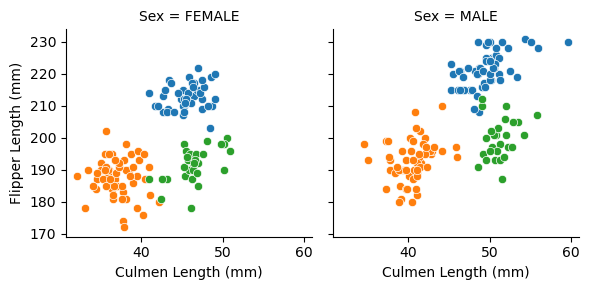

In [47]:
g = sns.FacetGrid(data = train, col = 'Sex', hue = 'Species')
g.map(sns.scatterplot, "Culmen Length (mm)", "Flipper Length (mm)")

With the data plotted, it becomes easy to see why this choice of features led to such a high accuracy. The data initially appears to be seperable, with only a few instances of near overlap. We can clearly identify the Gentoo penguins now with their comparably long flipper length, denoted as the blue points of data. In a similar vein, the Adelie penguins are seen as orange points, with a similar flipper length to the Chinstrap penguins but a much shorter culmen. We also can note that thh distribtution of these measurements across sexes are similar, with the data holding the same shape across the faceted graphs. 

#### Final Model and Decision Regions

With our features now appropriately selected, we can construct our final model and plot the associated decision regions. In order to plot our decision regions, we have constructed the plot_regions function below, which will create a similarly formatted set of graphs as we previously produced, but with shading showing the classifying regions and barriers. This will help us better understand how the model is making these decisions.

In [49]:
from matplotlib.patches import Patch

def plot_regions(model, X, y):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (7, 3))

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
      XY = pd.DataFrame({
          X.columns[0] : XX,
          X.columns[1] : YY
      })

      for j in qual_features:
        XY[j] = 0

      XY[qual_features[i]] = 1

      p = model.predict(XY)
      p = p.reshape(xx.shape)
      
      
      # use contour plot to visualize the predictions
      axarr[i].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
      
      ix = X[qual_features[i]] == 1
      # plot the data
      axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
      axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1])
      
      patches = []
      for color, spec in zip(["red", "green", "blue"], ["Adelie", "Chinstrap", "Gentoo"]):
        patches.append(Patch(color = color, label = spec))

      plt.legend(title = "Species", handles = patches, loc = "best")
      
      plt.tight_layout()

We then create our final Random Forest Classifying model, fitted using the training data, and plot the decision regions along with the test data.

1.0


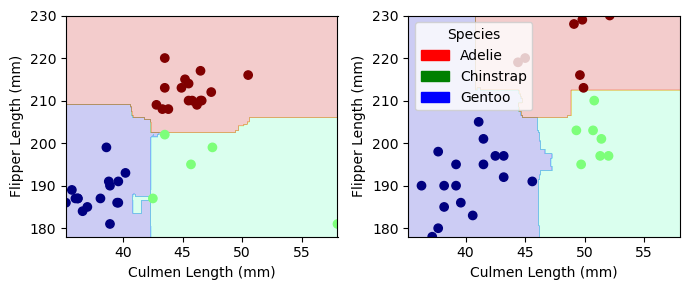

In [51]:
rfc = RandomForestClassifier()
cols = ["Culmen Length (mm)", "Flipper Length (mm)", "Sex_FEMALE", "Sex_MALE"]
rfc.fit(X_train[cols], y_train)
print(rfc.score(X_train[cols], y_train))

plot_regions(rfc, X_test[cols], y_test)

With the regions plotted, we can see exactly how the model makes predictions. We can also see potential overfitting in the female plot, where the Chinstrap region "leaks" into the Gentoo region. This was due to a notable point in the training data set, where a Chinstrap penguin had a notably short culmen. This did not prove to cause any inaccuracies in the scoring of our model, simply due to the fact that there were no data points near that region, but one could forsee that with additional data points, this could lead to inaccuracies. Generally speaking, however, the decision regions are rather well defined and in accordance with our exploratory analysis. 